### Here we check how GOOD the factorization from direct triplet behavioral data is by evaluating it on THINGS image similarity matrices, eg fully sampled RSMs from human data.

In [1]:
import numpy as np
import pandas as pd
from srf.io import load_things_image_data
from pathlib import Path
from tools.rsa import correlate_rsms, reconstruct_rsm_batched
from scipy.io import loadmat
from srf.mixed.admm import ADMM
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

/LOCAL/fmahner/srf/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ADMM: 0.901254987149011


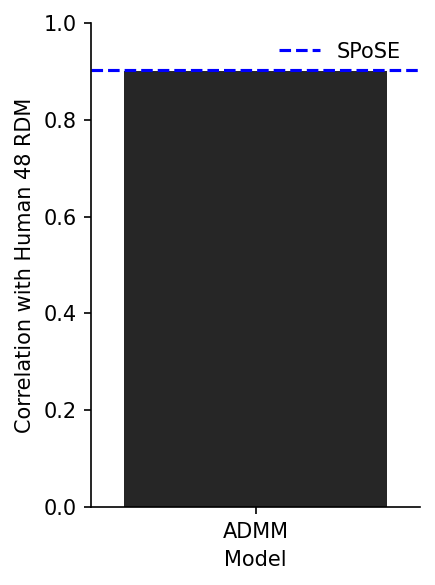

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare data
results_df = pd.read_csv("../results/sparse_spose_recon.csv")
model_data = results_df[results_df["Model"] != "SPoSE"]
spose_corr = results_df[results_df["Model"] == "SPoSE"]["Correlation"].iloc[0]

# print the correlation for each model
for model in model_data["Model"]:
    print(f"{model}: {model_data[model_data['Model'] == model]['Correlation'].iloc[0]}")

# Create visualization
fig, ax = plt.subplots(figsize=(3, 4), dpi=150)
sns.barplot(
    data=model_data,
    x="Model",
    y="Correlation",
    hue="Model",
    palette="dark:grey",
    ax=ax,
)

# Add VICE baseline
ax.axhline(y=spose_corr, color="blue", linestyle="--", label="SPoSE")

# Customize plot
sns.despine()
ax.set_xlabel("Model")
ax.set_ylabel("Correlation with Human 48 RDM")
ax.set_ylim(0, 1)
ax.legend(frameon=False)
plt.tight_layout()

plt.show()

In [64]:
from pathlib import Path

DATA_ROOT = Path("/LOCAL/fmahner/model-comparisons/data")
SPOSE_EMBEDDING_PATH = DATA_ROOT / "misc" / "spose_embedding_66d.txt"


dims = [3, 5, 8, 12, 14]  # subs    ample of the spose dimensions
spose_embedding = np.loadtxt(SPOSE_EMBEDDING_PATH)
spose_embedding = spose_embedding[:, dims]

In [74]:
from tools.rsa import correlate_rsms
from srf.helpers import add_noise_with_snr


hypothesis = spose_embedding[:, 0].reshape(-1, 1)

hypothesis_rsm = hypothesis @ hypothesis.T

spose_noise = add_noise_with_snr(spose_embedding, 0.3, rng=123)
spose_rsm_noisy = spose_noise @ spose_noise.T

w = ADMM(rank=5, max_outer=15, w_inner=10, tol=0.0, verbose=True, rho=1.0).fit_w(
    spose_rsm_noisy
)
spose_rsm_denoised = w @ w.T

corr = correlate_rsms(hypothesis_rsm, spose_rsm_noisy)
print(corr)

corr_denoised = correlate_rsms(hypothesis_rsm, spose_rsm_denoised)
print(corr_denoised)

0.30453819556944994
0.40809291945641335


In [68]:
spose_embedding.shape

(1854, 5)